# 词典与词频的结合

将词典与词频相结合，构造一些指标。比如Benguria等（2022）就使用了类似的方法研究贸易政策不确定性。

这里我仿照Benguria等（2022）的方法，使用（部分）金融新闻的标题数据，构造一个宏观政策不确定性的指数。

在Benguria等（2022），他们使用了两个不同的词典：
* 贸易政策词典：国际贸易、出口、进口、关税、壁垒、反倾销、外包、保护主义、单边主义
* 不确定性词典：不确定、不明确、不明朗、未明、（不明）、难料、难以估计、难以预计、难以预测、难以预料、风险、危险、危机、威胁、未知

我仿照他们的做法，选择一个与宏观经济政策有关的简单词典：
* 宏观政策词典：政策、宏观、货币、财政、土地

Benguria等（2022）使用了完整的报告，这里暂时只用标题。

首先导入数据：

In [42]:
import pandas as pd

StockNews = pd.read_csv("csv/stocknews1.csv")
StockNews['date'] = pd.to_datetime(StockNews['date'])
jianbao = StockNews['title'].str.match(
    r'(.+\d{4}年\d{2}月\d{2}日.+简报|.*二级市场.*简报|.*业绩公报.*|.*登记日期.*|.*交易安排表.*)')
StockNews = StockNews[~jianbao]
StockNews.head()

,id,date,title
0,59021767,2011-02-19,沪争取增值税扩围改革试点
1,59021769,2011-02-19,周小川：外部施压不会影响人民币升值步伐
2,59021771,2011-02-19,准备金率再上调 达到19.5％创新高
4,59021774,2011-02-19,定基价格指数若涨20% 政府或出手调控
5,59021776,2011-02-19,政策倾斜和加大投入 西藏将做大做强藏药产业


接下来定义模式，如果在句子中同时存在不确定性词典的词，以及宏观政策词典的词，那么就认为这是一条关于宏观政策不确定新的标题，具体做法可以使用正则表达式：

In [43]:
uncertainty_dict = [
    "不确定", "不明确", "不明朗", "未明", "不明", "难料", "难以估计", "难以预计", "难以预测", "难以预料",
    "风险", "危险", "危机", "威胁", "未知"
]
macro_dict = ["政策", "宏观", "货币", "财政", "土地", "经济", "改革", "中国"]

uncertainty_dict=['.*'+d+'.*' for d in uncertainty_dict]
macro_dict=['.*'+d+'.*' for d in macro_dict]
uncertainty_re = "(" + '|'.join(uncertainty_dict) + ")"
macro_re = "(" + '|'.join(macro_dict) + ")"
print(uncertainty_re)
print(macro_re)

StockNews['uncertainty'] = StockNews['title'].str.match(uncertainty_re)
StockNews['macro'] = StockNews['title'].str.match(macro_re)
StockNews['macro_uncertainty'] = StockNews['uncertainty'] & StockNews['macro']
StockNews['macro_uncertainty'].sum()

(.*不确定.*|.*不明确.*|.*不明朗.*|.*未明.*|.*不明.*|.*难料.*|.*难以估计.*|.*难以预计.*|.*难以预测.*|.*难以预料.*|.*风险.*|.*危险.*|.*危机.*|.*威胁.*|.*未知.*)
(.*政策.*|.*宏观.*|.*货币.*|.*财政.*|.*土地.*|.*经济.*|.*改革.*|.*中国.*)


2612

接下来根据年份对不确定性进行一个加总：

In [44]:
StockNews['year'] = pd.DatetimeIndex(StockNews['date']).year
aggregate_index = StockNews[['year',
                             'macro_uncertainty']].groupby('year').sum()
aggregate_index['count'] = StockNews[['year', 'macro_uncertainty'
                                      ]].groupby('year').count()
aggregate_index['ratio'] = aggregate_index['macro_uncertainty'] / (
    100 + aggregate_index['count']) * 1000
aggregate_index

,macro_uncertainty,count,ratio
year,,,
1900,0,41,0.000000
1986,0,1,0.000000
1992,0,1,0.000000
1993,0,13,0.000000
1994,0,16,0.000000
1995,0,33,0.000000
1996,0,38,0.000000
1997,0,44,0.000000
1998,0,30,0.000000


# 提取特征

将代码转换为可以识别的向量。常见的三种：词袋、TF-IDF以及词嵌入三种模型。

## 词袋模型

实际上词袋可以简单理解为每个文本的词频统计。我使用一些上市公司的标题数据，并使用上面介绍的方法将每个标题转换为向量：

In [45]:
RAW = pd.read_csv("csv/stocknews1.csv")
RAW['date'] = pd.to_datetime(RAW['date'])
RAW.head(10)

,id,date,title
0,59021767,2011-02-19,沪争取增值税扩围改革试点
1,59021769,2011-02-19,周小川：外部施压不会影响人民币升值步伐
2,59021771,2011-02-19,准备金率再上调 达到19.5％创新高
3,59021772,2011-02-19,浙江亚太药业股份有限公司股票2011年02月14日2011年02月18日二级市场表现周简报
4,59021774,2011-02-19,定基价格指数若涨20% 政府或出手调控
5,59021776,2011-02-19,政策倾斜和加大投入 西藏将做大做强藏药产业
6,59021778,2011-02-19,新疆13个地州探矿权年 590个项目涉嫌“圈而不探”
7,59021779,2011-02-19,沪士电子股份有限公司股票2011年02月14日2011年02月18日二级市场表现周简报
8,59021783,2011-02-19,北京：楼市限购首日成交环比降9成
9,59021787,2011-02-19,上海：房管局发布“沪九条”限购执行细则


这里额外进行一些处理，注意到其中的类似「2011年02月14日2011年02月18日二级市场表现周简报」之类的title很没有信息含量，可以使用正则表达式达到去除：

In [46]:
jianbao = RAW['title'].str.match(r'(.+\d{4}年\d{2}月\d{2}日.+简报|.*二级市场.*简报|.*业绩公报.*|.*登记日期.*|.*交易安排表.*)')
RAW1 = RAW.iloc[list(~jianbao), :]
RAW1

,id,date,title
0,59021767,2011-02-19,沪争取增值税扩围改革试点
1,59021769,2011-02-19,周小川：外部施压不会影响人民币升值步伐
2,59021771,2011-02-19,准备金率再上调 达到19.5％创新高
4,59021774,2011-02-19,定基价格指数若涨20% 政府或出手调控
5,59021776,2011-02-19,政策倾斜和加大投入 西藏将做大做强藏药产业
...,...,...,...
1134769,19839999,2006-12-27,定价基准不同 新利率基准将冲击旧浮动利率债
1134770,19840000,2006-12-27,债市延续调整格局 投资者宜缩短投资久期
1134771,19840023,2006-12-27,曾培炎:利用外汇储备优势
1134772,19840026,2006-12-27,广州小时最低工资标准7.5元


先对前十条信息进行处理：

In [47]:
data = RAW1.iloc[:10, :]
data

,id,date,title
0,59021767,2011-02-19,沪争取增值税扩围改革试点
1,59021769,2011-02-19,周小川：外部施压不会影响人民币升值步伐
2,59021771,2011-02-19,准备金率再上调 达到19.5％创新高
4,59021774,2011-02-19,定基价格指数若涨20% 政府或出手调控
5,59021776,2011-02-19,政策倾斜和加大投入 西藏将做大做强藏药产业
6,59021778,2011-02-19,新疆13个地州探矿权年 590个项目涉嫌“圈而不探”
8,59021783,2011-02-19,北京：楼市限购首日成交环比降9成
9,59021787,2011-02-19,上海：房管局发布“沪九条”限购执行细则
10,59021789,2011-02-19,6.5781！人民币升值容忍度继续提高？
11,59021791,2011-02-19,2010年上海商品住宅销售降四成


In [48]:
## 首先进行分词、去除停用词等
import jieba

with open('Chinese/stopword.txt', 'rt') as f: #使用现有的停用词表
    stoplist = f.readlines()
    stoplist = [w.replace('\n', '') for w in stoplist]


def tokenize(w):
    cut_w = jieba.cut(w)
    ## 去除停用词
    cut_w = [
        w.strip().lower() for w in cut_w
        if w.strip().lower() not in stoplist and len(w.strip()) > 0
    ]
    return cut_w


tokenized_data = map(tokenize, data['title'])
tokenized_data = list(tokenized_data)
tokenized_data

[['沪', '增值税', '扩围', '改革', '试点'],
 ['周小川', '外部', '施压', '影响', '人民币', '升值', '步伐'],
 ['准备金率', '上调', '19.5', '创新', '高'],
 ['定基', '价格指数', '若涨', '20%', '政府', '出手', '调控'],
 ['政策', '倾斜', '加大', '投入', '西藏', '做', '做', '强', '藏药', '产业'],
 ['新疆', '地州', '探矿权', '590', '项目', '涉嫌', '圈', '不探'],
 ['北京', '楼市', '限购', '首日', '成交', '环', '比降', '成'],
 ['上海', '房管局', '发布', '沪', '九条', '限购', '执行', '细则'],
 ['6.5781', '人民币', '升值', '容忍度', '提高'],
 ['2010', '上海', '商品住宅', '销售', '降', '四成']]

In [49]:
## 接下来进行词频统计


def word_freq(wlist):
    freq = {}
    for w in wlist:
        if w in freq:
            freq[w] += 1
        else:
            freq[w] = 1

    return freq


freqs = map(word_freq, tokenized_data)
## 放在pandas里
pd_freqs = pd.DataFrame(freqs)
## 把NaN换成0
pd_freqs = pd_freqs.fillna(0)
pd_freqs.head(10)

,沪,增值税,扩围,改革,试点,周小川,外部,施压,影响,人民币,...,执行,细则,6.5781,容忍度,提高,2010,商品住宅,销售,降,四成
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


如此，一个词袋模型就完成

注意到，这个矩阵是一个较大的稀疏矩阵，在SciPy和Pandas里面都提供了稀疏矩阵的存储结构和运算，所以更好的办法是使用稀疏矩阵进行存储：

In [50]:
sparse_freqs = pd_freqs.astype(pd.SparseDtype("float", 0))
sparse_freqs.head(10)

,沪,增值税,扩围,改革,试点,周小川,外部,施压,影响,人民币,...,执行,细则,6.5781,容忍度,提高,2010,商品住宅,销售,降,四成
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


实际上很多自然语言处理包已经有比较成熟的词袋处理机制。比如在Scikit-Learn中已经准备好了词袋的提取函数：

In [51]:
import jieba

with open('Chinese/stopword.txt', 'rt') as f:
    stoplist = f.readlines()
    stoplist = [w.replace('\n', '') for w in stoplist]

from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(tokenizer=jieba.cut,
                             stop_words=stoplist,
                             min_df=1)
bag_words = count_vect.fit_transform(data['title'])
words_names = count_vect.get_feature_names_out()
bag_words

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['##', 'a', 'ain', 'aren', 'c', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'i', 'isn', 'lex', 'll', 'm', 'mon', 'null', 's', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn', '±', '÷', 'β', 'δ', 'λ', 'ξ', 'ψ', 'в', '′', '″', 'ⅲ', '∈', '∧', '∪', '─', '☆', '一会', '一关', '一城', '一堆', '一对', '一批', '一方', '一期', '一村', '一根', '一派', '一班', '一百', '一眼', '一科', '一群', '一遍', '一道', '一部', '一集', '一页', '一颗', '三鲜', '为什', '什', '倒', '傥', '元', '元素', '先', '关', '兼', '前', '单元', '吨', '唷', '啪', '啷', '喔', '喜欢', '外', '多年', '大节', '大道', '大面儿', '天', '始', '子弹', '後', '抗拒', '敞开', '新', '昉', '更远', '有意', '

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 72 stored elements and shape (10, 64)>

由于Scikit-Learn中一般只支持英文的自动分词，为了能够处理中文的分词，把jieba.cut函数提交给了CountVectorizer，此外额外提供了停用词列表。min_df选项设置了如果在所有文本中某个词出现的频率下线，如果出现太少则会被忽略，适当提高这个选项可以降低维数。

上面的词袋结果是一个sparse matrix，实际上是SciPy中的系数矩阵形式，实际分析时已经可以使用。

为了查看方便，将其转换为Pandas的数据框：

In [52]:
bag_words_df = pd.DataFrame.sparse.from_spmatrix(bag_words,
                                                 columns=words_names)
bag_words_df.head(10)

,,19.5,20%,2010,590,6.5781,上海,上调,不探,九条,...,藏药,西藏,试点,调控,销售,降,限购,项目,首日,高
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
5,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0


显然上面的结果中，「13，19.5，20%」等都不是想要的结果，然而用停用词根本不可能将这些数字去除。

这是因为分词和去除停用词等操作应该是第二步清洗数据完成的，现在如果都放到向量化的对象CountVectorizer中来，非常不灵活。

将两者手工清洗+自动计算词袋结合起来可以解决：

In [53]:
import jieba
import re

with open('Chinese/stopword.txt', 'rt') as f:
    stoplist = f.readlines()
    stoplist = [w.replace('\n', '') for w in stoplist]


def not_digit(w):
    w = w.replace(',', '')
    if re.match(r'\d+', w) != None or re.match(r'\d%', w) != None or re.match(
            r'\d*\.\d+', w) != None:
        return False
    else:
        return True


def tokenize(w):
    cut_w = jieba.cut(w)
    ## 去除停用词
    cut_w = [
        w.strip().lower() for w in cut_w
        if ((w.strip().lower() not in stoplist) and not_digit(w) and len(w.strip()) > 0)
    ]
    return cut_w


tokenized_data = map(tokenize, data['title'])
tokenized_data = [' '.join(t) for t in tokenized_data]
tokenized_data

['沪 增值税 扩围 改革 试点',
 '周小川 外部 施压 影响 人民币 升值 步伐',
 '准备金率 上调 创新 高',
 '定基 价格指数 若涨 政府 出手 调控',
 '政策 倾斜 加大 投入 西藏 做 做 强 藏药 产业',
 '新疆 地州 探矿权 项目 涉嫌 圈 不探',
 '北京 楼市 限购 首日 成交 环 比降 成',
 '上海 房管局 发布 沪 九条 限购 执行 细则',
 '人民币 升值 容忍度 提高',
 '上海 商品住宅 销售 降 四成']

In [54]:
count_vect = CountVectorizer()
bag_words = count_vect.fit_transform(tokenized_data)
words_names = count_vect.get_feature_names_out()
bag_words_df = pd.DataFrame.sparse.from_spmatrix(bag_words,
                                                 columns=words_names)
bag_words_df.head(10)

,上海,上调,不探,九条,产业,人民币,价格指数,倾斜,准备金率,出手,...,细则,若涨,藏药,西藏,试点,调控,销售,限购,项目,首日
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
7,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


更简单的方式是直接将手写的tokenize函数调入

In [55]:
count_vect = CountVectorizer(tokenizer=tokenize)
bag_words = count_vect.fit_transform(data['title'])
words_names = count_vect.get_feature_names_out()
bag_words_df = pd.DataFrame.sparse.from_spmatrix(bag_words,
                                                 columns=words_names)
bag_words_df.head(10)

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,上海,上调,不探,九条,产业,人民币,价格指数,倾斜,做,准备金率,...,藏药,西藏,试点,调控,销售,降,限购,项目,首日,高
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,2,0,...,1,1,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


以上是一个一元的词袋，还可以做一个二元的词袋

In [56]:
count_vect = CountVectorizer(tokenizer=tokenize, ngram_range=(2, 2))
bag_words = count_vect.fit_transform(data['title'])
words_names = count_vect.get_feature_names_out()
bag_words_df = pd.DataFrame.sparse.from_spmatrix(bag_words,
                                                 columns=words_names)
bag_words_df.head(10)

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,上海 商品住宅,上海 房管局,上调 创新,九条 限购,人民币 升值,价格指数 若涨,倾斜 加大,做 做,做 强,准备金率 上调,...,环 比降,若涨 政府,藏药 产业,西藏 做,销售 降,降 四成,限购 执行,限购 首日,项目 涉嫌,首日 成交
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,1,0,...,0,0,1,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
7,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


# TF-IDF模型

比如，对于之前计算的词袋：

In [57]:
count_vect = CountVectorizer(tokenizer=tokenize)
bag_words = count_vect.fit_transform(tokenized_data)
words_names = count_vect.get_feature_names_out()
bag_words_df = pd.DataFrame.sparse.from_spmatrix(bag_words,
                                                 columns=words_names)
bag_words_df.head(10)

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,上海,上调,不探,九条,产业,人民币,价格指数,倾斜,做,准备金率,...,藏药,西藏,试点,调控,销售,降,限购,项目,首日,高
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,2,0,...,1,1,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


以上计算略显复杂，Scikit-Learn中也给出了方便的计算函数：

In [58]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(norm='l2').fit(
    bag_words)  ##使用L2范数，并fit模型（如计算IDF等）
tfidf_words = tfidf_transformer.transform(bag_words)  ##变换数据
tfidf_words_df = pd.DataFrame.sparse.from_spmatrix(tfidf_words,
                                                   columns=words_names)
tfidf_words_df

,上海,上调,不探,九条,产业,人民币,价格指数,倾斜,做,准备金率,...,藏药,西藏,试点,调控,销售,降,限购,项目,首日,高
0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.460158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.00000,0.000000,0.334845,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.5,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.5,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5
3,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.408248,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.0,0.000000,0.00000,0.288675,0.000000,0.000000,0.288675,0.57735,0.0,...,0.288675,0.288675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.0,0.377964,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377964,0.000000,0.0
6,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.305902,0.000000,0.359846,0.0
7,0.317517,0.0,0.000000,0.37351,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317517,0.000000,0.000000,0.0
8,0.000000,0.0,0.000000,0.00000,0.000000,0.457985,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,0.391176,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.460158,0.460158,0.000000,0.000000,0.000000,0.0


# 词嵌入

我使用1992年到2016年的CSMAR上式公司新闻全文数据训练了不同维度的词向量，保存在“Chinese/word2vec/”文件夹中（由于文件很大，在这个文件夹汇总值保留了30维模型的训练结果，更多维数的结果可以联系我：zhaoguowei0912@gmail.com

其中"word2vec.py"为训练代码，由于数据量太大（共有74885004个词汇参与训练），不提供该原始数据，如有需要可以从CSMAR下载。"word2vec**"位已经训练好的词向量模型，其中\*\*为词向量的维度，我训练了30、100、300、500等不同维度。如果需要导入预训练的模型，可以直接使用load函数：

In [59]:
# import gensim

# CORPUS=map(tokenize,RAW1['title'])
# w2v_model=gensim.models.Word2Vec(CORPUS, window=5, size=10, min_count=5)
# w2v_model.save('word2vec')
# ##后面节省时间，先把模型保存下来

In [41]:
pip uninstall scipy

Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Would remove:
    /Users/mac/anaconda3/lib/python3.11/site-packages/scipy-1.10.1.dist-info/*
    /Users/mac/anaconda3/lib/python3.11/site-packages/scipy/*
Proceed (Y/n)? ^C
Note: you may need to restart the kernel to use updated packages.


In [60]:
import gensim

w2v_model = gensim.models.Word2Vec.load(
    './Chinese/word2vec/word2vec30')  ##节省时间，直接导入预训练的模型


ImportError: cannot import name 'triu' from 'scipy.linalg' (/Users/mac/anaconda3/lib/python3.11/site-packages/scipy/linalg/__init__.py)

scipy和gensim版本不兼容问题

In [62]:
import Levenshtein

Levenshtein距离是指两个字符串之间，由一个转换成另一个所需的最少编辑操作次数。允许的编辑操作包括：

- 插入一个字符

- 删除一个字符

- 替换一个字符

这个距离越小，说明两个字符串越相似。

相似度比率（Ratio） 是一个衡量两个字符串相似程度的指标，通常用百分比表示。一个常见的计算公式是：

ratio = (1 - (编辑距离 / 两个字符串的最大长度)) * 100%

或者更常用的（也是Python的python-Levenshtein库所使用的）公式是：

ratio = ( (len(a) + len(b)) - dist ) / (len(a) + len(b)) ) * 100

这个值越接近100%，说明两个字符串越相似。



In [63]:
Levenshtein.distance('intention', 'execution')

5

In [64]:
Levenshtein.distance('今天天气真好', '明天天气不错')

3

In [65]:
Levenshtein.ratio('intention', 'execution')

0.5555555555555556

In [66]:
Levenshtein.ratio('今天天气真好', '明天天气不错')

0.5

## 文本相似度

In [67]:
import numpy as np

cos_similarity = lambda u, v: np.inner(u, v) / (np.linalg.norm(u) * np.linalg.
                                                norm(v))


In [68]:
##计算词袋
count_vect = CountVectorizer(tokenizer=tokenize)
bag_words = count_vect.fit_transform(data['title'])
words_names = count_vect.get_feature_names_out()
bag_words_df = pd.DataFrame.sparse.from_spmatrix(bag_words,
                                                 columns=words_names)


/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [69]:
cos_similarity(bag_words_df.sparse.to_dense().iloc[7, :], bag_words_df.sparse.to_dense().iloc[9, :])


0.15811388300841897

In [70]:
##计算词袋
count_vect = CountVectorizer(tokenizer=tokenize)
bag_words = count_vect.fit_transform(RAW1['title'][:50000])
words_names = count_vect.get_feature_names_out()
bag_words_df = pd.DataFrame.sparse.from_spmatrix(bag_words,
                                                 columns=words_names)
##计算相关系数（自己用循环试一下，奇慢无比，如果不向量化计算，估计要跑的时间按天算）
ip = np.array(np.dot(bag_words_df, bag_words_df.sparse.to_dense().iloc[0, :]))  ## 这里用到了广播
norm1 = np.array(np.linalg.norm(bag_words_df, axis=1))  ## 第一行的norm都一样，所以不用除
corr = ip / norm1
corr = corr[1:]
##找最大值
argi = np.argmax(corr)
print(RAW1['title'].iloc[0])
print(RAW1['title'].iloc[argi + 1])


/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


沪争取增值税扩围改革试点
增值税扩围和资源税改革今年有望取得突破


# 文本分类：情感分析

情感分析（sentiment analysis）最初指对文本的情感，比如褒义还是贬义，以及文章中的情感倾向进行分析，实际上是文本分类的一种。实际上，我们之前学到过的所有的监督学习方法都可以使用在文本分类中。然而，监督学习需要大量的带有标签的词典，有时这种方法是行不通的，所以也会有根据特定模式对文本进行分类的方法，或者使用预训练模型的方法。比如，一个经常使用的方法是使用情感词典。

## 基于词典

情感词典即标记了情感得分的一个词典，这个词典可以看作是一个预训练的模型，模型的训练结果是情感得分，而我们只需要使用这些情感得分就可以得到情感的具体取值。

情感词典方法的好处是非常的简单：只需要简单计算得分即可。然而缺点也是非常突出的：情感词典通常不对特殊问题进行优化，此外其标签是固定的。比如，一般情感词典也许会标记正面负面，但是当将其用在金融领域时，会发现“降准”这个正向词汇甚至不会出现在情感词典中，虽然这个词在金融领域应该对股票市场是一个正向词汇。

此外，不同情境下也许同一个词也有不同的情感倾向，比如如果我们讨论股票，“降准”也许是一个正向词汇，然而如果我们讨论的是债券，“降准”就不见得是什么好词了。

当然，情感词典在一般的领域中应用也许也可以达到比较高的精准度。在这里我们先介绍情感词典的使用方法。

使用情感词典的第一步是获得情感词典，这里有几个比较常用的情感词典：

* 清华大学李军中文褒贬义词典（ http://nlp.csai.tsinghua.edu.cn/site2/index.php/13-sms ）（./Chinese/BosonNLP/）
* 知网HowNet情感词典（./Chinese/HowNet/）
* 玻森公司是情感词典（ http://static.bosonnlp.com/dev/resource ）（./Chinese/Tsinghua/）
* 金融领域中文情绪词典（姚加权等，2021）（./Chinese/FinanceSenti）

以上词典都可以在括号中的地址，或者括号中的路径里面找到。

比如，对于一个句子，可以先将其使用词袋模型将其整理为词袋，然后对于每个词都是用其情感值对其进行打分，并处理否定词，最后根据每个词的打分情况汇总为这个句子的情感。

比如，以HowNet的情感词典为例，其情感词典的内容大约为：

In [72]:
with open("Chinese/HowNet/正面情感词语（中文）.txt", encoding='gb18030') as f:
    posilist = f.readlines()
del posilist[0]
SentDict = {}
for w in posilist:
    SentDict[w.strip()] = 1


In [73]:
SentDict = {}
Files = ['面情感词语（中文）.txt', '面情感词语（英文）.txt', '面评价词语（中文）.txt', '面评价词语（英文）.txt']
for p in ['正', '负']:
    v = (1 if p == '正' else -1)
    for f in Files:
        with open("Chinese/HowNet/" + p + f, encoding='gb18030') as f:
            posilist = f.readlines()
        del posilist[0]
        for w in posilist:
            if w not in SentDict:
                SentDict[w.strip()] = v
            else:
                SentDict[w.strip()] += v


In [74]:
# 导入否定词
NegaList = []
with open("Chinese/negative.txt") as f:
    for w in f:
        NegaList.append(w.strip())
print(NegaList)

['no', '不', '没', '无', '非', '莫', '弗', '毋', '未', '否', '别', '无', '不够', '不是', '不可', '不曾', '未必', '没有', '不要', '难以', '未曾', '否认', '取消', '撤回']


这里使用一个大众点评的文本进行情感分析

In [75]:
import pandas as pd

dianping = pd.read_csv("csv/dianping.csv")
dianping.head()

,cus_id,comment_time,comment_star,cus_comment,kouwei,huanjing,fuwu,shopID,stars,year,month,weekday,hour,comment_len
0,迷糊泰迪,2018-09-20 06:48:00,sml-str40,南信 算是 广州 著名 甜品店 吧 好几个 时间段 路过 都 是 座无虚席 看着 餐单 上 ...,非常好,好,好,518986,4.0,2018,9,3,6,184
1,稱霸幼稚園,2018-09-22 21:49:00,sml-str40,中午 吃 完 了 所谓 的 早茶 回去 放下 行李 休息 了 会 就 来 吃 下午茶 了 服...,很好,很好,很好,518986,4.0,2018,9,5,21,266
2,爱吃的美美侠,2018-09-22 22:16:00,sml-str40,冲刺 王者 战队 吃遍 蓉城 战队 有 特权 五月份 和 好 朋友 毕业 旅行 来 了 广州...,很好,很好,很好,518986,4.0,2018,9,5,22,341
3,姜姜会吃胖,2018-09-19 06:36:00,sml-str40,都 说来 广州 吃 糖水 就要 来南信 招牌 姜撞奶 红豆 双皮奶 牛 三星 云吞面 一楼 ...,非常好,很好,很好,518986,4.0,2018,9,2,6,197
4,forevercage,2018-08-24 17:58:00,sml-str50,一直 很 期待 也 最 爱 吃 甜品 广州 的 甜品 很 丰富 很 多样 来 之前 就 一直...,非常好,很好,很好,518986,5.0,2018,8,4,17,261


In [76]:
import numpy as np


def score(s):
    w_list = str(s).split(' ')
    multiplier = 1
    senti = 0
    for w in w_list:
        if w in NegaList:
            multiplier *= (-1)
        if w in SentDict and w not in NegaList:
            senti += (multiplier * SentDict[w])
            multiplier = 1
    return np.sign(senti)


dianping['score'] = dianping['cus_comment'].map(score)


In [77]:
# 为了查看分类效果，简单的可以分类求均值：
dianping[['stars', 'score']].groupby('stars').describe()


score                                              
         count      mean       std  min   25%  50%  75%  max
stars                                                       
1.0      797.0  0.225847  0.866277 -1.0 -1.00  1.0  1.0  1.0
2.0      982.0  0.423625  0.817602 -1.0  0.00  1.0  1.0  1.0
3.0     5152.0  0.629076  0.689405 -1.0  0.75  1.0  1.0  1.0
4.0    10849.0  0.787169  0.534707 -1.0  1.00  1.0  1.0  1.0
5.0     9067.0  0.835999  0.465336 -1.0  1.00  1.0  1.0  1.0

In [78]:
# 可以看到评分越高，用户的评星也越高，结果可以接受。
# 不过即使是1星，最终的评分平均也是大于0的，所以在使用的时候也可能会出现问题，
# 即很多评分为正的实际上却是负面评价，比如如果我们根据评分计算：
dianping[['stars', 'score']].groupby('score').describe()


stars                                             
         count      mean       std  min  25%  50%  75%  max
score                                                      
-1      2062.0  3.337536  1.200654  1.0  3.0  3.0  4.0  5.0
 0      2766.0  3.755965  1.092184  1.0  3.0  4.0  5.0  5.0
 1     22019.0  4.072710  0.900757  1.0  4.0  4.0  5.0  5.0

# 基于机器学习

如果数据中存在标签，可以使用之前学过的机器学习方法，以标签作为输出，以提取特征的做法作为输入，通过机器学习算法进行文本分类。

一般可以使用结合Lasso等方法的回归（linear/logistic/ordered/count/...），或者使用支持向量机、贝叶斯方法、决策树、随机森林等非线性、非参数的方法。也可以通过构建神经网络的方法，结合LSTM、RNN等网络设计方法进行分类。此外，还可以使用BERT等预训练模型进行fine-tuning，这种预训练模型允许我们在小样本的条件下达到更好的预测效果。


下面对豆瓣评分的数据进行有监督学习。Gentzkow、Kelly和Taddy（2017）建议在样本量不是特别大的情况下，尽量少引入决策树、支持向量机等非线性方法，所以这里我选择使用Logistic回归的方法，将评分在4星及以下的设为0，5星设为1，进行一个简单的二分类预测。

In [79]:
dianping = pd.read_csv("csv/dianping.csv")
dianping['y'] = dianping['stars'] > 4

In [80]:
# 简单清洗
dianping['cus_comment'] = dianping['cus_comment'].str.replace(' ', '')
dianping['len_comment'] = dianping['cus_comment'].str.len()
dianping = dianping[dianping['len_comment'] > 1]
dianping


,cus_id,comment_time,comment_star,cus_comment,kouwei,huanjing,fuwu,shopID,stars,year,month,weekday,hour,comment_len,y,len_comment
0,迷糊泰迪,2018-09-20 06:48:00,sml-str40,南信算是广州著名甜品店吧好几个时间段路过都是座无虚席看着餐单上密密麻麻满满当当好吃的容易范选...,非常好,好,好,518986,4.0,2018,9,3,6,184,False,97.0
1,稱霸幼稚園,2018-09-22 21:49:00,sml-str40,中午吃完了所谓的早茶回去放下行李休息了会就来吃下午茶了服务两层楼楼下只能收现金楼上可以微信支...,很好,很好,很好,518986,4.0,2018,9,5,21,266,False,175.0
2,爱吃的美美侠,2018-09-22 22:16:00,sml-str40,冲刺王者战队吃遍蓉城战队有特权五月份和好朋友毕业旅行来了广州我们都是双皮奶爱好者搜到啦最火的...,很好,很好,很好,518986,4.0,2018,9,5,22,341,False,238.0
3,姜姜会吃胖,2018-09-19 06:36:00,sml-str40,都说来广州吃糖水就要来南信招牌姜撞奶红豆双皮奶牛三星云吞面一楼现金二楼微信支付宝位置不少但是...,非常好,很好,很好,518986,4.0,2018,9,2,6,197,False,122.0
4,forevercage,2018-08-24 17:58:00,sml-str50,一直很期待也最爱吃甜品广州的甜品很丰富很多样来之前就一直想着一定要过来吃到腻今天总算实现了先...,非常好,很好,很好,518986,5.0,2018,8,4,17,261,True,176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32478,darayan,2007-04-28 16:57:00,NAN,我觉得姜撞奶一般咯有苦公司岩搬过来东风西呢边下午茶仲会时不时定下甜品不过就无乜惊喜咯都系中意...,一般,一般,一般,521698,NaN,2007,4,5,16,68,False,55.0
32479,chenjj920,2006-10-27 09:12:00,NAN,味道啦还算正宗值得一试,好,一般,一般,521698,NaN,2006,10,4,9,16,False,11.0
32480,winny311111,2018-05-14 03:09:00,sml-str50,第二次来好吃第二次来好吃第二次来好吃,非常好,非常好,非常好,521698,5.0,2018,5,0,3,24,True,18.0
32481,Polykat_年嫿,2018-04-28 02:33:00,sml-str50,兒時的味道兒時的味道兒時的味道,非常好,很好,好,521698,5.0,2018,4,5,2,15,True,15.0


In [81]:
##接下来处理文本数据，使用简单的词袋模型作为预测特征
import jieba
import re
from sklearn.feature_extraction.text import CountVectorizer
with open('Chinese/stopword.txt', 'rt') as f:
    stoplist = f.readlines()
    stoplist = [w.replace('\n', '') for w in stoplist]


def not_digit(w):
    w = w.replace(',', '')
    if re.match(r'\d+', w) != None or re.match(r'\d%', w) != None or re.match(
            r'\d*\.\d+', w) != None:
        return False
    else:
        return True


def tokenize(w):
    cut_w = jieba.cut(w)
    ## 去除停用词
    cut_w = [
        w.strip().lower() for w in cut_w
        if ((w not in stoplist) and not_digit(w) and len(w.strip()) > 0)
    ]
    return cut_w


count_vect = CountVectorizer(tokenizer=tokenize, min_df=5)
bag_words = count_vect.fit_transform(dianping['cus_comment'])
words_names = count_vect.get_feature_names_out()


/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


接下来做一个简单降维操作（由于使用了Lasso降维，这一步也许可以不做，不过做的话可以降低运行时间）。将TF-IDF值比较低的特征剔除掉，从而达到降维。

或者，这一步也可以考虑其他的降维方法，比如Fan(2007)的screening方法等。

In [82]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bag_words)  ##使用L2范数，并fit模型（如计算IDF等）
tfidf_words = tfidf_transformer.transform(bag_words)  ##变换数据
tfidf_words_df = pd.DataFrame.sparse.from_spmatrix(tfidf_words,
                                                   columns=words_names)
tfidf_words_df

,一丁点,一万个,一上,一下下,一下子,一不小心,一丝,一丝丝,一两个,一两口,...,齁,齐全,齐名,齿,龍,龙,龙津,龜苓,龟,龟苓膏
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
tfidf_sum = tfidf_words_df.sum(axis=0)
quantile_tfidf = tfidf_sum.quantile(0.3)
print(quantile_tfidf)
tfidf_sub = tfidf_sum[tfidf_sum > quantile_tfidf]
tfidf_words_df = tfidf_words_df.loc[:, tfidf_sub.index]
tfidf_words_df

1.9101411518232896


,一丁点,一下下,一下子,一不小心,一丝,一两个,一两次,一两碗,一个个,一个多,...,齁,齐全,齐名,齿,龍,龙,龙津,龜苓,龟,龟苓膏
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


开始训练模型......


/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型训练完成......


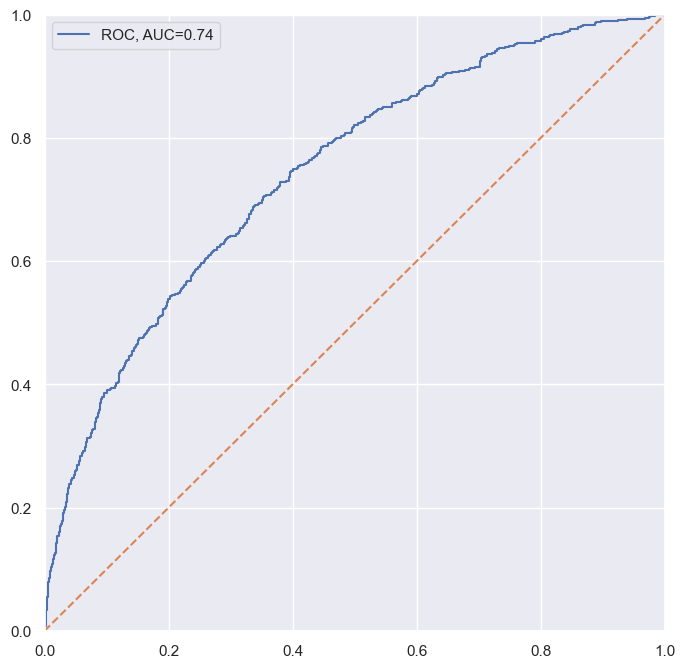

In [84]:
##训练模型
print("开始训练模型......")
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(tfidf_words_df.iloc[:30000,:], dianping['y'].iloc[:30000])  ## 训练模型
LR.coef_
print("模型训练完成......")
## 预测及概率
dianping['prob']=LR.predict_proba(tfidf_words_df)[:,1]
dianping['pred']=dianping['prob']>=0.5
# 画图
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(dianping['y'][30000:], dianping['prob'][30000:])
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.plot(fpr,tpr,label='ROC, AUC=%.2f' % roc_auc)
plt.legend(loc='upper left', frameon=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

以上只是一个简单的模型，没有调参数，还可以更好